# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import yfinance as yf
from datetime import date
import datetime 

# Helper Functions

In [2]:
def retrive_data(company):
    start_date = '2010-01-01' # Setting a static start date
    end_date = date.today() # End date is today
    data = yf.download(company, start_date, end_date)
    data = data[["Close"]] #We only require the closeing price for the stock and the date which is the index
    return data



In [3]:
data = retrive_data('MSFT') # Getting the data for Apple

[*********************100%%**********************]  1 of 1 completed


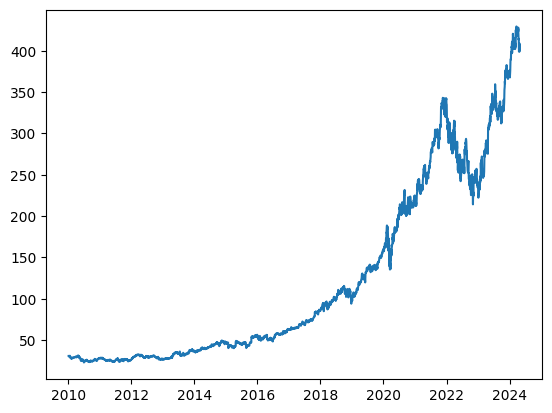

In [4]:
plt.plot(data.index, data["Close"])

In [5]:
df = data.copy()

In [6]:
import datetime
import pandas as pd
import numpy as np

# Function to convert string date to datetime object
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Function to create a windowed DataFrame
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert first and last date strings to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    # Initialize variables
    target_date = first_date
    dates = []
    X, Y = [], []

    # Loop until target date reaches last date
    while True:
        # Select subset of DataFrame up to target date and take the last n+1 rows
        df_subset = dataframe.loc[:target_date].tail(n+1)
        
        # Check if there are enough rows in the subset
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        # Extract features (X) and target (Y) from the subset
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        # Store date, features, and target
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Find the next target date
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        # Break the loop if it's the last date
        if target_date == last_date:
            break
        
        # Update target date
        target_date = next_date

    # Create DataFrame to store results
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    # Convert X to numpy array for easier manipulation
    X = np.array(X)
    # Add columns to the DataFrame for each feature
    for i in range(0, n):
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    # Add target column to the DataFrame
    ret_df['Target'] = Y

    return ret_df

# Example usage
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [7]:
# Function to convert a windowed DataFrame to date, features (X), and target (Y)
def windowed_df_to_date_X_y(windowed_dataframe):
    # Convert windowed DataFrame to numpy array
    df_as_np = windowed_dataframe.to_numpy()

    # Extract dates from the first column of the numpy array
    dates = df_as_np[:, 0]

    # Extract features (X) from the second to second-to-last columns of the numpy array
    middle_matrix = df_as_np[:, 1:-1]
    # Reshape the feature matrix to have a third dimension of size 1
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    # Extract target (Y) from the last column of the numpy array
    Y = df_as_np[:, -1]

    # Return dates, features (X), and target (Y)
    return dates, X.astype(np.float32), Y.astype(np.float32)

# Call the function to convert windowed DataFrame to date, features (X), and target (Y)
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Print the shapes of dates, features (X), and target (Y)
dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

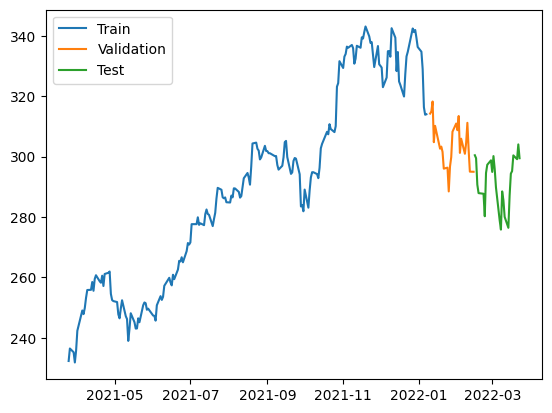

In [8]:
# Calculate indices for splitting the data into train, validation, and test sets
q_80 = int(len(dates) * .8)  # 80% of the data for training
q_90 = int(len(dates) * .9)  # 10% of the data for validation and test each

# Split dates, features (X), and target (y) into train set
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

# Split dates, features (X), and target (y) into validation set
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

# Split dates, features (X), and target (y) into test set
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Plot the target values for train, validation, and test sets
plt.plot(dates_train, y_train)  # Plot train set
plt.plot(dates_val, y_val)      # Plot validation set
plt.plot(dates_test, y_test)    # Plot test set

# Add legend to the plot
plt.legend(['Train', 'Validation', 'Test'])

In [9]:
# Import necessary modules from TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Define the model architecture
model = Sequential([
    layers.Input((3, 1)),           # Define input shape (3 time steps, 1 feature)
    layers.LSTM(64),                # LSTM layer with 64 units
    layers.Dense(32, activation='relu'),  # Dense layer with 32 units and ReLU activation function
    layers.Dense(32, activation='relu'),  # Dense layer with 32 units and ReLU activation function
    layers.Dense(1)                 # Output layer with 1 unit (for regression)
])

# Compile the model
model.compile(loss='mse',                           # Mean Squared Error loss function
              optimizer=Adam(learning_rate=0.001),   # Adam optimizer with learning rate 0.001
              metrics=['mean_absolute_error'])      # Monitor mean absolute error during training

# Train the model
model.fit(X_train,                             # Training features
          y_train,                             # Training targets
          validation_data=(X_val, y_val),      # Validation data
          epochs=150)                          # Number of epochs (training iterations)

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 83421.5469 - mean_absolute_error: 287.0706 - val_loss: 92281.6797 - val_mean_absolute_error: 303.6918
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 84248.2031 - mean_absolute_error: 288.5217 - val_loss: 92051.6797 - val_mean_absolute_error: 303.3129
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 84713.3750 - mean_absolute_error: 289.3171 - val_loss: 91761.1406 - val_mean_absolute_error: 302.8336
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 84675.1875 - mean_absolute_error: 289.3296 - val_loss: 91455.2422 - val_mean_absolute_error: 302.3281
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 83106.4688 - mean_absolute_error: 286.6227 - val_loss: 91082.6875 - val_mean_absolute_error: 301.7113
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 83171.5703 - mean_absolute_error: 286.6953 - val_loss: 90577.8125 - val_mean_absolute_error: 300.8734
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/s

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


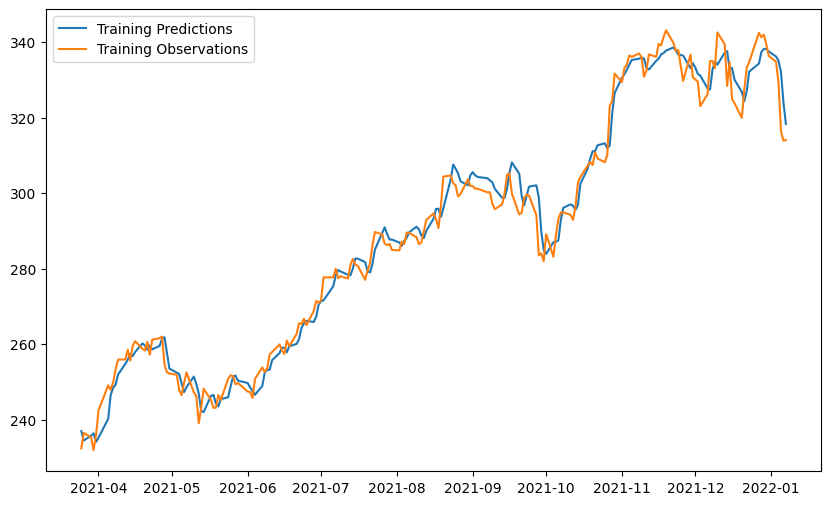

In [10]:
# generating a plot comparing training predictions and observations using a trained model
train_predictions = model.predict(X_train).flatten()
plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


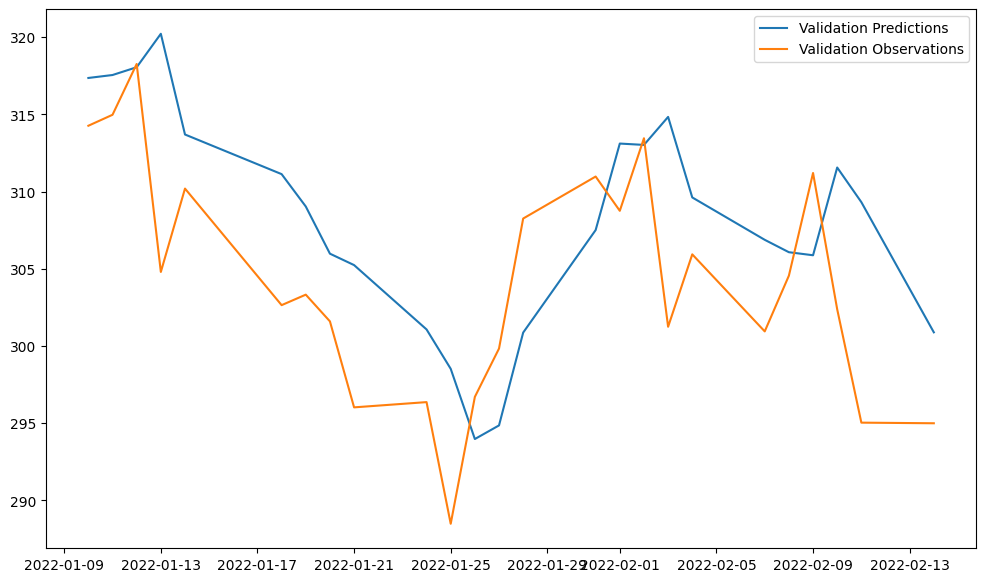

In [11]:
# generating a plot comparing validation predictions and observations using a trained model
val_predictions = model.predict(X_val).flatten()
plt.figure(figsize=(12, 7))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


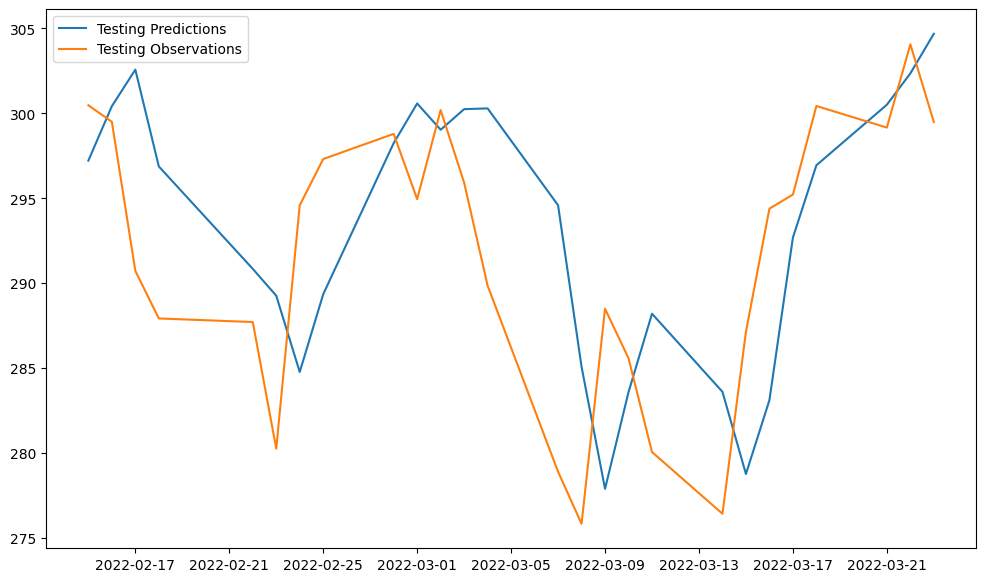

In [12]:
# generating a plot comparing testing predictions and observations using a trained model
test_predictions = model.predict(X_test).flatten()
plt.figure(figsize=(12, 7))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

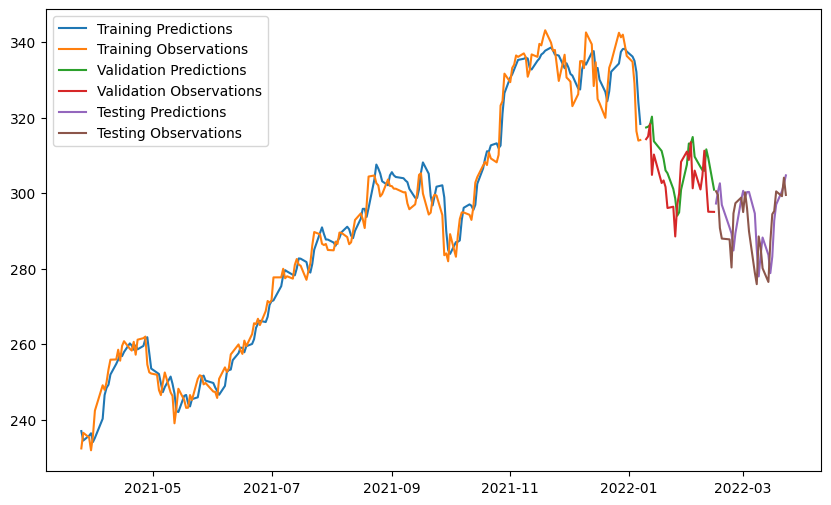

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [14]:
# Importing necessary module
from copy import deepcopy

# Initializing lists to store recursive predictions and dates
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

# Iterate over each target date for recursive prediction
for target_date in recursive_dates:
    # Create a deep copy of the last window of training data
    last_window = deepcopy(X_train[-1])
    
    # Predict the next value based on the last window
    next_prediction = model.predict(np.array([last_window])).flatten()
    
    # Append the prediction to the list of recursive predictions
    recursive_predictions.append(next_prediction)
    
    # Update the last window with the new prediction
    last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

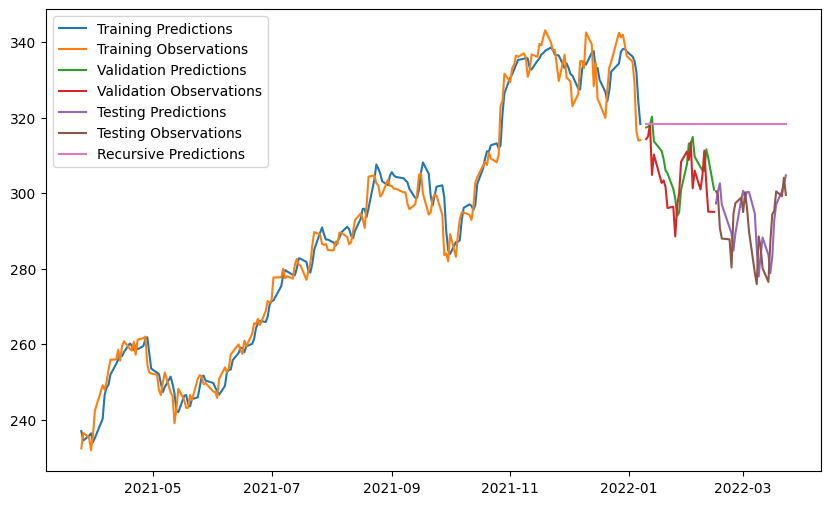

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])